# Advanced Lane Lines

---

## Module Imports

---

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from scipy import signal
from sklearn.metrics import mean_squared_error

## Camera Calibration

---

In [2]:
def calibrate_camera():
    
    obj_point_container = []
    img_point_container = []
    
    # The number of corners
    nx = 9
    ny = 6

    # Import images 
    images = glob.glob('camera_cal/calibration*.jpg')

    # Preparing the object's corners
    obj_point = np.zeros((ny*nx,3), np.float32)
    obj_point[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    for index, file_name in enumerate(images):
        image = cv2.imread(file_name)
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray_image, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            # draw and display the corners
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            obj_point_container.append(obj_point)
            img_point_container.append(corners)
            
    return (obj_point_container, img_point_container)



## Undistort Camera

---

In [3]:
def undistort_camera(img_points, obj_points, img):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size,None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)

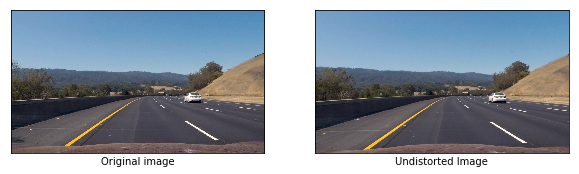

In [4]:
obj_point, img_point = calibrate_camera()
img = mpimg.imread('test_images/test3.jpg')
undistorted_img = undistort_camera(img_point, obj_point, img)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(undistorted_img)
plt.xlabel('Undistorted Image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

## Perspective Transform

---

In [5]:
def transform_perspective (img, src_coords, dst_coords):
    M = cv2.getPerspectiveTransform(src_coords, dst_coords)
    
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_NEAREST)

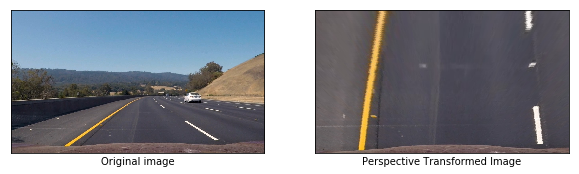

In [6]:
src_coords = np.float32([
    [490,482],
    [810,482],
    [1250,720],
    [40,720]
])

dst_coords = np.float32([
    [0,0],
    [1280,0],
    [1250,720],
    [40,720]
])
img = mpimg.imread('test_images/test3.jpg')
undistorted_img = undistort_camera(img_point, obj_point, img)
perspective_transform_img = transform_perspective(undistorted_img, src_coords, dst_coords)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(1, 2, 2)
plt.imshow(perspective_transform_img)
plt.xlabel('Perspective Transformed Image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

## Binary Thresholds

--- 

In [7]:
def s_channel(img, threshold_min, threshold_max):
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= threshold_min) & (s_channel <= threshold_max)] = 1
    return s_binary

def l_channel(img, threshold_min, threshold_max):
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= threshold_min) & (l_channel <= threshold_max)] = 1
    return l_binary

def combine_binary(s_binary, l_binary):
    binary = np.zeros_like(s_binary)
    binary[(l_binary == 1) | (s_binary == 1)] = 1
    return binary

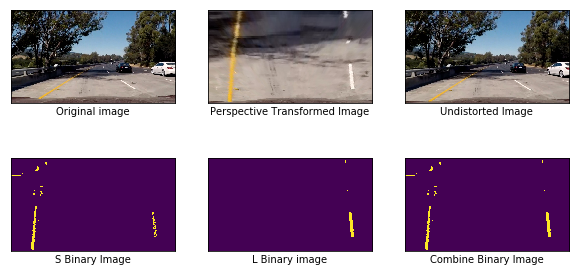

In [8]:
img = mpimg.imread('test_images/test5.jpg')
undistorted_img = undistort_camera(img_point, obj_point, img)
perspective_transform_img = transform_perspective(undistorted_img, src_coords, dst_coords)

s_binary = s_channel(perspective_transform_img, 180, 255)
l_binary = l_channel(perspective_transform_img, 225, 255)
combine_binarys = combine_binary(s_binary, l_binary)

plt.figure(figsize=(10,5))
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.xlabel('Original image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 2)
plt.imshow(perspective_transform_img)
plt.xlabel('Perspective Transformed Image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 3)
plt.imshow(undistorted_img)
plt.xlabel('Undistorted Image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 4)
plt.imshow(s_binary)
plt.xlabel('S Binary Image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 5)
plt.imshow(l_binary)
plt.xlabel('L Binary image')
plt.xticks([], [])
plt.yticks([], [])

plt.subplot(2, 3, 6)
plt.imshow(combine_binarys)
plt.xlabel('Combine Binary Image')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

## Lane Detection

---

### Helper Function

In [9]:
def center(y, left_poly, right_poly):
    
    return (1.5 * evaluate_poly(y, left_poly) - evaluate_poly(y, right_poly)) / 2

def collapse_into_single_arrays(left_x, left_y, right_x, right_y): 
    left_x = [x
             for array in left_x
             for x in array]
    left_y = [x
             for array in left_y
             for x in array]
    right_x = [x
              for array in right_x
              for x in array]
    right_y = [x
              for array in right_y
              for x in array]

    left_x = np.array(left_x)
    left_y = np.array(left_y)
    right_x = np.array(right_x)
    right_y = np.array(right_y)

    return left_x, left_y, right_x, right_y

def draw_poly(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

def evaluate_poly(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

def fit_second_order_poly(indep, dep, return_coeffs=False):
    fit = np.polyfit(indep, dep, 2)
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    if return_coeffs == True:
        return fitdep, fit
    else:
        return fitdep

def highlight_lane_line_area(mask_template, left_poly, right_poly, start_y=0, end_y =720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly(y, left_poly)
        right = evaluate_poly(y, right_poly)
        area_mask[y][int(left):int(right)] = 1
    
    return area_mask

def histogram_pixels(img, offset=0, steps=6, window_radius=200, medianfilt_kernel_size=51, horizontal_offset=50):
    left_x, left_y, right_x, right_y = ([] for i in range(4))

    height = img.shape[0]
    offset_height = height - offset
    width = img.shape[1]
    half_frame = img.shape[1] // 2
    pixels_per_step = offset_height / steps

    for step in range(steps):
        left_x_window_centers, right_x_window_centers, y_window_centers = ([] for i in range(3))

        window_start_y = height - (step * pixels_per_step) + offset
        window_end_y = window_start_y - pixels_per_step + offset
        histogram = np.sum(img[int(window_end_y):int(window_start_y), int(horizontal_offset):int(width - horizontal_offset)], axis=0)
        histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

        left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
        right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
        
        if len(left_peaks) > 0:
            left_peak = max(left_peaks)
            left_x_window_centers.append(left_peak)

        if len(right_peaks) > 0:
            right_peak = max(right_peaks) + half_frame
            right_x_window_centers.append(right_peak)

        if len(left_peaks) > 0 or len(right_peaks) > 0:
            y_window_centers.append((window_start_y + window_end_y) // 2)

        left_x, left_y = get_window_pixels(left_x_window_centers, y_window_centers, img, window_radius, left_x, left_y)

        right_x, right_y = get_window_pixels(right_x_window_centers, y_window_centers, img, window_radius, right_x, right_y)

    return collapse_into_single_arrays(left_x, left_y, right_x, right_y)

def lane_poly(y_val, poly_coeffs):
    return poly_coeffs[0]*y_val**2 + poly_coeffs[1]*y_val + poly_coeffs[2]

def get_pixel_in_window(img, x_center, y_center, size):
    half_size = size // 2
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y

def get_window_pixels (x_window_centers, y_window_centers, img, window_radius, x_array, y_array):
    for x_center, y_center in zip(x_window_centers, y_window_centers):
        x_additional, y_additional = get_pixel_in_window(img, x_center, y_center, window_radius)
        x_array.append(x_additional)
        y_array.append(y_additional)
    
    return (x_array, y_array)

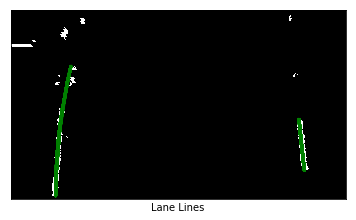

Left coeffs: [  2.43504723e-04  -3.42145115e-01   2.91528538e+02]
righty[0]: , 560.0 , rightx[0]:  1104
Right coeffs:  [  8.43704184e-05   1.92959307e-02   1.07914910e+03]


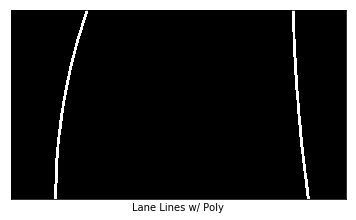

Left coeffs:  [  2.43504723e-04  -3.42145115e-01   2.91528538e+02]
Right fit:  [  8.43704184e-05   1.92959307e-02   1.07914910e+03]


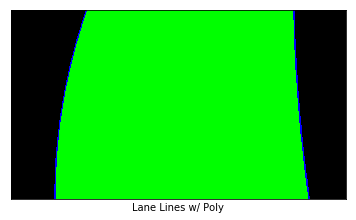

In [10]:


left_x, left_y, right_x, right_y = histogram_pixels(combine_binarys, horizontal_offset=40)
left_fit, left_coeffs = fit_second_order_poly(left_y, left_x, return_coeffs=True)
right_fit, right_coeffs = fit_second_order_poly(right_y, right_x, return_coeffs=True)

plt.plot(left_fit, left_y, color='green', linewidth=3)
plt.plot(right_fit, right_y, color='green', linewidth=3)
plt.imshow(combine_binarys, cmap="gray")
plt.xlabel('Lane Lines')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

print("Left coeffs:", left_coeffs)
print("righty[0]: ,", right_y[0], ", rightx[0]: ", right_x[0])
print("Right coeffs: ", right_coeffs)

polyfit_left = draw_poly(np.zeros((720, 1280)), lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)

plt.imshow(polyfit_drawn, cmap="gray")
plt.xlabel('Lane Lines w/ Poly')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)

trace = cv2.cvtColor(np.zeros((720, 1280)).astype(np.uint8), cv2.COLOR_GRAY2RGB)
trace[polyfit_drawn > 1] = [0,0,255]
area = highlight_lane_line_area(np.zeros((720, 1280)), left_coeffs, right_coeffs)
trace[area == 1] = [0,255,0]

plt.imshow(trace)
plt.xlabel('Lane Lines w/ Poly')
plt.xticks([], [])
plt.yticks([], [])
plt.show()

In [11]:
y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5)/(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5)/(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad, "pixels")
print("Right lane curve radius: ", right_curverad, "pixels")
curvature = (left_curverad + right_curverad) / 2
centers = center(719, left_coeffs, right_coeffs)
min_curvature = min(left_curverad, right_curverad)

Left lane curve radius:  2083.38943943 pixels
Right lane curve radius:  6022.03544317 pixels


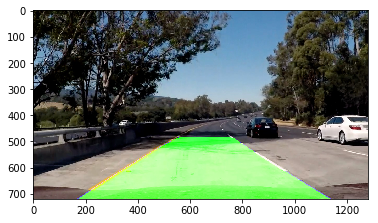

In [12]:
# Warp lane boundaries back onto original image

Minv = cv2.getPerspectiveTransform(dst_coords, src_coords)

lane_lines = cv2.warpPerspective(trace, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

# Convert to color
combined_img = cv2.add(lane_lines, img)
plt.imshow(combined_img)
plt.show()

## Image Pipeline

--- 

In [15]:
def image_pipeline(img):   
    src_coords = np.float32([
        [490,482],
        [810,482],
        [1250,720],
        [40,720]
    ])
    
    dst_coords = np.float32([
        [0,0],
        [1280,0],
        [1250,720],
        [40,720]
    ])
    
    y_eval = 500
    
    s_binarys, l_binarys, combine_binarys = ([] for i in range(3))
    
    undistorted_img = undistort_camera(img_point, obj_point, img)
    
    perspective_transform_img = transform_perspective(undistorted_img, src_coords, dst_coords)
    
    s_binarys = s_channel(perspective_transform_img, 180, 255)
    l_binarys = l_channel(perspective_transform_img, 225, 255)
    combine_binarys = combine_binary(s_binary, l_binary)
    
    left_x, left_y, right_x, right_y = histogram_pixels(combine_binarys, horizontal_offset=40)
    
    left_fit, left_coeffs = fit_second_order_poly(left_y, left_x, return_coeffs=True)
    right_fit, right_coeffs = fit_second_order_poly(right_y, right_x, return_coeffs=True)
    
    polyfit_left = draw_poly(np.zeros((720, 1280)), lane_poly, left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
    
    trace = cv2.cvtColor(np.zeros((720, 1280)).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    trace[polyfit_drawn > 1] = [0,0,255]
    area = highlight_lane_line_area(np.zeros((720, 1280)), left_coeffs, right_coeffs)
    trace[area == 1] = [0,255,0]
    
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5)/(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5)/(2 * right_coeffs[0]))
    
    curvature = (left_curverad + right_curverad) / 2
    centers = center(719, left_coeffs, right_coeffs)
    min_curvature = min(left_curverad, right_curverad)
    
    Minv = cv2.getPerspectiveTransform(dst_coords, src_coords)

    lane_lines = cv2.warpPerspective(trace, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return cv2.add(lane_lines, img)

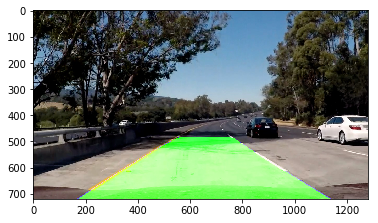

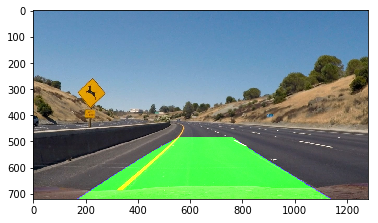

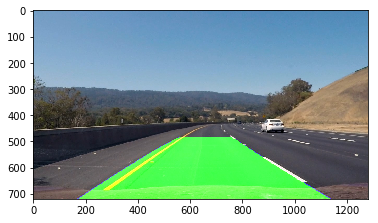

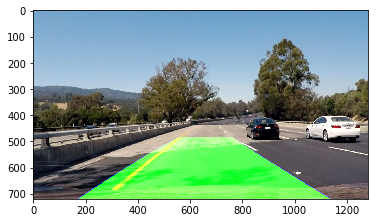

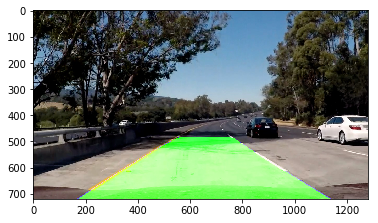

In [16]:
img_5 = mpimg.imread('test_images/test5.jpg')
image_5 = image_pipeline(img_5)
plt.imshow(image_5)
plt.show()

img_2 = mpimg.imread('test_images/test2.jpg')
image_2 = image_pipeline(img_2)
plt.imshow(image_2)
plt.show()

img_3 = mpimg.imread('test_images/test3.jpg')
image_3 = image_pipeline(img_3)
plt.imshow(image_3)
plt.show()

img_4 = mpimg.imread('test_images/test4.jpg')
image_4 = image_pipeline(img_4)
plt.imshow(image_4)
plt.show()

img_5 = mpimg.imread('test_images/test5.jpg')
image_5 = image_pipeline(img_5)
plt.imshow(image_5)
plt.show()

In [40]:
vid_output = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')

vid_clip = clip.fl_image(image_pipeline)
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [18:10<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 18min 56s, sys: 20.5 s, total: 19min 16s
Wall time: 18min 11s
